# **HW2**

### Importing the Libraries

In [1]:
#some of the libraries are imported in necessary cells
import numpy as np
import gzip
import matplotlib.pyplot as plt
import math

### Mounting the Google Drive for dataset

In [2]:
#To mount google drive, I put my dataset into my drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
#To change directory in google drive
import os
os.chdir('/content/drive/MyDrive/CS464/HW2/data')

In [ ]:
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)


Current Working Directory: /content/drive/MyDrive/CS464/HW2/data


##Q1


### Importing the Dataset

In [ ]:
# Function to read pixel data from the dataset
def read_pixels(data_path):
    with gzip.open(data_path) as f:
        pixel_data = np.frombuffer(f.read(), 'B', offset=16).astype('float32')
    normalized_pixels = pixel_data / 255
    flattened_pixels = normalized_pixels.reshape(60000,784)
    return flattened_pixels

In [ ]:
# Function to read label data from the dataset
def read_labels(data_path):
    with gzip.open(data_path) as f:
        label_data = np.frombuffer(f.read(), 'B', offset=8)
    return label_data

In [ ]:
images = read_pixels("train-images-idx3-ubyte.gz")

In [ ]:
images.shape

(60000, 784)

In [ ]:
labels = read_labels("train-labels-idx1-ubyte.gz")

In [ ]:
labels.shape

(60000,)

### PCA

In [ ]:
def pca(dataset, num_components):
    # Calculate the mean of each feature
    mean_vec = np.mean(dataset, axis=0)

    # Center the data by subtracting the mean from each feature
    centered_data = dataset - mean_vec

    # Calculate the covariance matrix
    covariance_matrix = np.cov(centered_data, rowvar=False)

    # Calculate eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Convert eigenvalues to real numbers
    eigenvalues = eigenvalues.real

    # Sort eigenvalues and corresponding eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Retain the top num_components eigenvectors
    top_eigenvectors = eigenvectors[:, :num_components]

    # Project the original data onto the principal components
    projected_data = np.dot(centered_data, top_eigenvectors)

    return projected_data, eigenvalues, top_eigenvectors, eigenvectors

### Apply PCA

In [ ]:
# Specify the number of principal components to retain
num_components = 10

# Apply PCA to the data
projected_data, eigenvalues, eigenvectors, all_eigenvectors = pca(images, num_components)

In [ ]:
# Calculate the total sum of eigenvalues
total_eigenvalue_sum = np.sum(eigenvalues)

# Calculate the proportion of variance explained (PVE) for each component
pve_per_component = eigenvalues / total_eigenvalue_sum

# Cumulative PVE for the first 10 components
cumulative_pve = np.cumsum(pve_per_component[:num_components])

# Print the PVE for each component and the cumulative PVE for the first 10 components
for i in range(num_components):
    print(f"Component {i + 1}: PVE = {pve_per_component[i]:.4f}")

print("\nCumulative PVE for the first 10 components:")
print(cumulative_pve)

Component 1: PVE = 0.0970
Component 2: PVE = 0.0710
Component 3: PVE = 0.0617
Component 4: PVE = 0.0539
Component 5: PVE = 0.0487
Component 6: PVE = 0.0431
Component 7: PVE = 0.0327
Component 8: PVE = 0.0288
Component 9: PVE = 0.0276
Component 10: PVE = 0.0236

Cumulative PVE for the first 10 components:
[0.09704664 0.16800588 0.22969677 0.28359097 0.33227894 0.37540125
 0.40812055 0.4369595  0.4645798  0.4881498 ]


In [ ]:
# Cumulative PVE for all components
cumulative_pve = np.cumsum(pve_per_component)

# Specify the desired percentage of variance to explain
desired_variance_percentage = 0.90

# Find the number of components needed to explain the desired percentage of variance
num_components_for_desired_variance = np.argmax(cumulative_pve >= desired_variance_percentage) + 1

# Print the result
print(f"Number of components needed to explain {desired_variance_percentage*100}% of the variance: {num_components_for_desired_variance}")


Number of components needed to explain 90.0% of the variance: 87


###Re-Construct the Image

In [ ]:
# Function to apply min-max scaling to an array
def min_max_scale(arr):
    min_val = np.min(arr)
    max_val = np.max(arr)
    scaled_arr = (arr - min_val) / (max_val - min_val)
    return scaled_arr

In [ ]:
# Get the top 10 eigenvectors
top_eigenvectors = eigenvectors[:, :100]

# Reshape each eigenvector to a 28x28 matrix and apply min-max scaling
scaled_principal_components = [min_max_scale(component.reshape(28, 28)) for component in top_eigenvectors.T]

###Visualize the Image

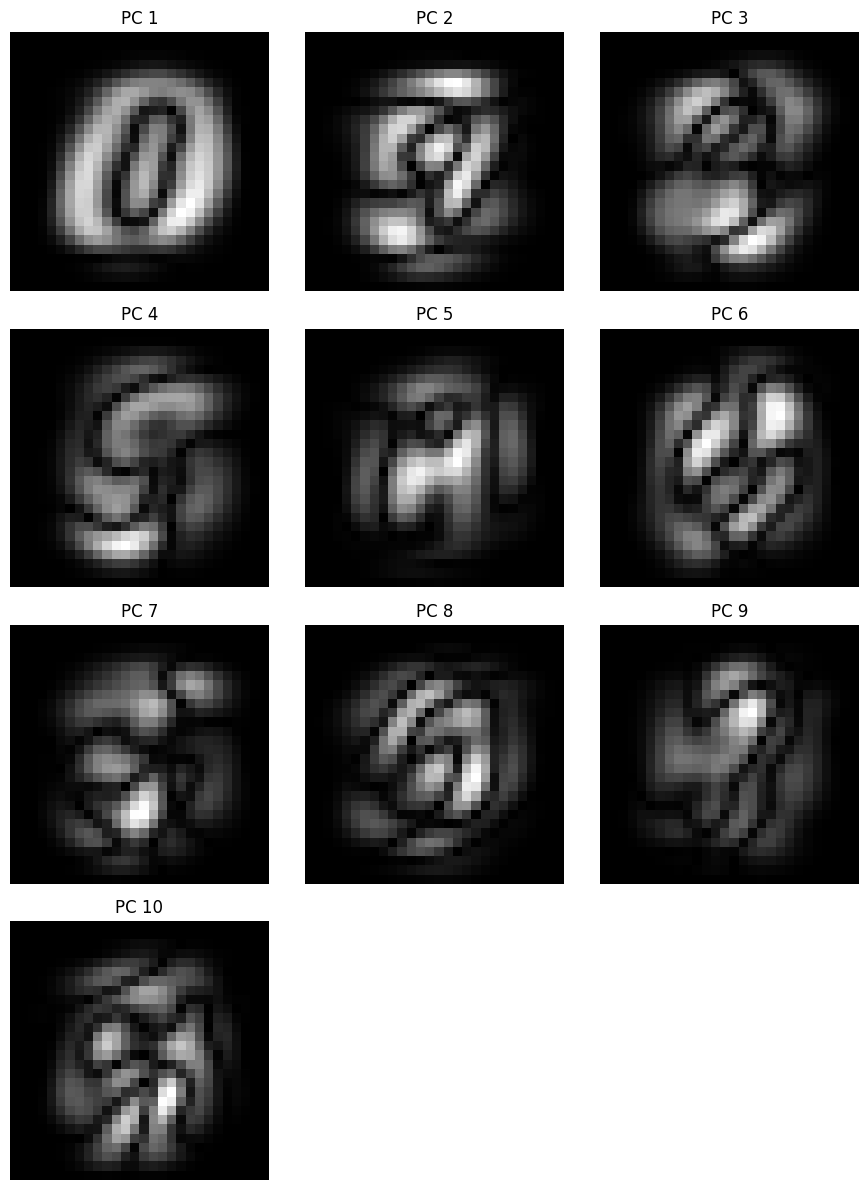

In [ ]:
# Specify the number of principal components to visualize
num_components_to_visualize = 10

# Calculate the number of rows and columns for the subplot grid
num_rows = math.ceil(math.sqrt(num_components_to_visualize))
num_cols = math.ceil(num_components_to_visualize / num_rows)

# Get the top N eigenvectors
top_eigenvectors = all_eigenvectors[:, :num_components_to_visualize]

# Ensure that the principal components are real and take the absolute value
scaled_principal_components = [min_max_scale(np.abs(component.reshape(28, 28))) for component in top_eigenvectors.T]

# Calculate the figure size based on the number of components
fig_size = (num_cols * 3, num_rows * 3)  # Adjust the multiplier as needed

# Plot the grayscale images of the principal components
plt.figure(figsize=fig_size)
for i in range(num_components_to_visualize):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(scaled_principal_components[i], cmap='gray')
    plt.title(f'PC {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


### Project Images

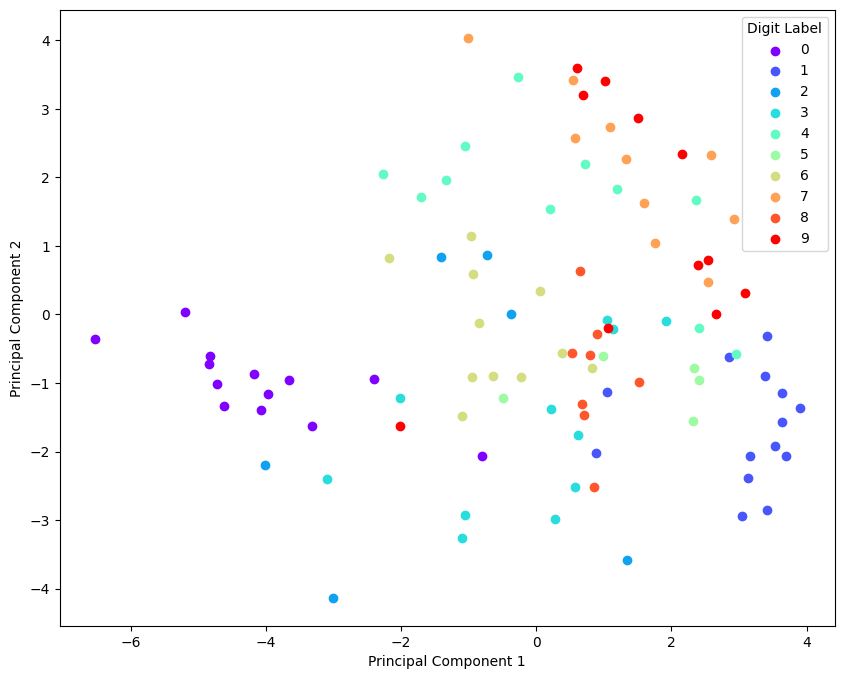

In [ ]:
# Project the first 100 images onto the first 2 principal components
num_images_to_project = 100
projected_data_2d = projected_data[:num_images_to_project, :2]

# Create a color map for different digit labels
colors = plt.cm.rainbow(np.linspace(0, 1, 10))

# Plot the projected data points with colored labels
plt.figure(figsize=(10, 8))
for label, color in zip(range(10), colors):
    indices = labels[:num_images_to_project] == label
    plt.scatter(projected_data_2d[indices, 0], projected_data_2d[indices, 1], color=color, label=str(label))

# Label the axes
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add a legend
plt.legend(title='Digit Label')

# Show the plot
plt.show()

### Re-Construct the First Image

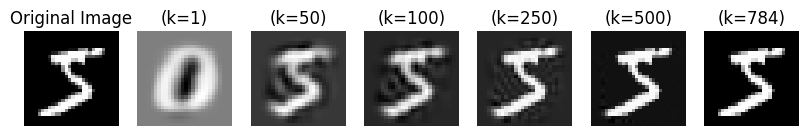

In [ ]:
# Specify the values of k
k_values = [1, 50, 100, 250, 500, 784]

# Choose the index of the image to reconstruct (e.g., the first image)
image_index = 0
original_image = images[image_index]

# Plot the original image
plt.figure(figsize=(10, 5))
plt.subplot(2, len(k_values) + 1, 1)
plt.imshow(original_image.reshape(28, 28), cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Reconstruct the image using different values of k
for i, k in enumerate(k_values):
    # Project the original image onto the first k principal components
    projected_data_k = np.dot(original_image, all_eigenvectors[:, :k])

    # Reconstruct the image using the projected data and the first k principal components
    reconstructed_image = np.dot(projected_data_k, all_eigenvectors[:, :k].T).astype(float)

    # Plot the reconstructed image
    plt.subplot(2, len(k_values) + 1, i + 2)
    plt.imshow(reconstructed_image.reshape(28, 28), cmap='Greys_r')
    plt.title(f'(k={k})')
    plt.axis('off')

plt.show()

## Q2


### Importing the Dataset & Data Prepocessing

In [15]:
def one_hot_encoding(label_data):
    unique_labels = list(set(label_data))
    num_labels = len(unique_labels)

    encoded_labels = []
    for label in label_data:
        encoding = [0] * num_labels
        encoding[unique_labels.index(label)] = 1
        encoded_labels.append(encoding)

    return np.array(encoded_labels)

In [16]:
# Function to read pixel data from the dataset
def read_pixels(data_path):
    with gzip.open(data_path) as f:
        pixel_data = np.frombuffer(f.read(), 'B', offset=16).astype('float32')
    normalized_pixels = pixel_data / 255
    flattened_pixels = normalized_pixels.reshape(-1,784)
    return flattened_pixels

In [17]:
# Function to read label data from the dataset
def read_labels(data_path):
    with gzip.open(data_path) as f:
        label_data = np.frombuffer(f.read(), 'B', offset=8)
    one_hot_encoding_labels = one_hot_encoding(label_data)
    return one_hot_encoding_labels

In [18]:
# Function to read the entire dataset
def read_dataset():
    X_train = read_pixels("train-images-idx3-ubyte.gz")
    y_train = read_labels("train-labels-idx1-ubyte.gz")
    X_test = read_pixels("t10k-images-idx3-ubyte.gz")
    y_test = read_labels("t10k-labels-idx1-ubyte.gz")
    return X_train, y_train, X_test, y_test

In [19]:
X_train, y_train, X_test, y_test = read_dataset()

In [20]:
# Split the first 10000 rows for validation
X_validation = X_train[:10000]
y_validation = y_train[:10000]

# Update the training data to exclude the validation data
X_train = X_train[10000:]
y_train = y_train[10000:]

In [21]:
X_train.shape

(50000, 784)

In [22]:
y_train.shape

(50000, 10)

In [23]:
X_test.shape

(10000, 784)

In [24]:
y_test.shape

(10000, 10)

In [25]:
X_validation.shape

(10000, 784)

In [26]:
y_validation.shape

(10000, 10)

### Losigtic Regression

In [5]:
def softmax(z):
    # Subtracting the maximum value helps prevent overflow issues.
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [6]:
def initialize_weights(input_dim, num_classes, initialization='normal'):
    if initialization == 'zero':
        return np.zeros((input_dim, num_classes))
    elif initialization == 'uniform':
        return np.random.uniform(size=(input_dim, num_classes))
    elif initialization == 'normal':
        return np.random.normal(0, 1, (input_dim, num_classes))
    else:
        raise ValueError("Invalid weight initialization method. Supported methods are 'normal', 'zeros', and 'ones'.")

In [7]:
def logistic_regression(X, weights):
    logits = np.dot(X, weights)
    return softmax(logits)

In [8]:
def compute_loss(X, y, softmax_probs, weights, l2_reg_coefficient):
    # Cross-entropy loss (normalized)
    #loss = -np.sum(y * np.log(softmax_probs)) / len(X)
    epsilon = np.finfo(float).eps
    loss = -np.sum(y * np.log(softmax_probs + epsilon)) / len(X)

    # L2 regularization
    l2_reg = 0.5 * l2_reg_coefficient * np.sum(weights**2)

    return loss + l2_reg

In [9]:
def gradient_descent(X, y, softmax_probs, weights, learning_rate, l2_reg_coefficient):
    # Backward pass (Gradient Descent)
    #gradient = (-1 / len(X)) * np.dot(X.T, (y - softmax_probs))
    gradient = (-1) * np.dot(X.T, (y - softmax_probs))
    # Combine the derivative of the L2 regularization with the gradient
    gradient += l2_reg_coefficient * weights

    return gradient

In [10]:
def train_logistic_regression(X_train, y_train, X_validation, y_validation, input_dim, num_classes, weight_initialization='normal', learning_rate=5e-4, batch_size=200, l2_reg_coefficient=1e-4, epochs=100):
    # Initialize weights
    weights = initialize_weights(input_dim, num_classes, weight_initialization)

    # Record accuracies at each epoch
    epoch_accuracies = []

    # Training
    for epoch in range(epochs):
        shuffle_indices = np.random.permutation(len(X_train))
        X_train_shuffled = X_train[shuffle_indices]
        y_train_shuffled = y_train[shuffle_indices]

        for batch_start in range(0, len(X_train), batch_size):
            X_batch = X_train_shuffled[batch_start: batch_start + batch_size]
            y_batch = y_train_shuffled[batch_start: batch_start + batch_size]

            # Forward pass
            logits = logistic_regression(X_batch, weights)

            # Compute loss
            loss = compute_loss(X_batch, y_batch, logits, weights, l2_reg_coefficient)

            # Backward pass (Gradient Descent)
            grad = gradient_descent(X_batch, y_batch, logits, weights, learning_rate, l2_reg_coefficient)

            # Update weights
            weights -= learning_rate * grad

        # Evaluate on validation set
        accuracy_validation, _ = evaluate_model(X_validation, y_validation, weights)
        epoch_accuracies.append((epoch + 1, accuracy_validation))

        # Print the loss and accuracy for each epoch
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss}, Validation Accuracy: {accuracy_validation * 100:.2f}%")

    return weights, np.array(epoch_accuracies)

In [11]:
from sklearn.metrics import confusion_matrix

def evaluate_model(X_validation, y_validation, weights):
    # Validation
    softmax_probs_validation = logistic_regression(X_validation, weights)
    predicted_labels_validation = np.argmax(softmax_probs_validation, axis=1)
    accuracy_validation = np.mean(predicted_labels_validation == np.argmax(y_validation, axis=1))
    print(f"Validation Accuracy: {accuracy_validation * 100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(np.argmax(y_validation, axis=1), predicted_labels_validation)

    return accuracy_validation, cm

In [12]:
import seaborn as sns

def plot_confusion_matrix(cm, num_classes):
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

### Train the default model

In [ ]:
#Default Hyperparameters
num_classes = 10
input_dim = X_train.shape[1]
weight_initialization='normal'
learning_rate = 5e-4
batch_size = 200
l2_reg_coefficient = 1e-4
epochs = 100

# Train Logistic Regression Model
trained_weights, default_epoch_accuracy = train_logistic_regression(X_train, y_train, X_validation, y_validation, input_dim, num_classes, weight_initialization, learning_rate, batch_size, l2_reg_coefficient, epochs)

Validation Accuracy: 64.11%
Epoch 1/100, Loss: 2.506613814124005, Validation Accuracy: 64.11%
Validation Accuracy: 73.88%
Epoch 2/100, Loss: 1.59784565830843, Validation Accuracy: 73.88%
Validation Accuracy: 78.26%
Epoch 3/100, Loss: 1.4236082579255773, Validation Accuracy: 78.26%
Validation Accuracy: 80.47%
Epoch 4/100, Loss: 1.6875230281500744, Validation Accuracy: 80.47%
Validation Accuracy: 81.92%
Epoch 5/100, Loss: 1.250496871084946, Validation Accuracy: 81.92%
Validation Accuracy: 83.04%
Epoch 6/100, Loss: 1.1325418803958818, Validation Accuracy: 83.04%
Validation Accuracy: 83.82%
Epoch 7/100, Loss: 1.0913279181261604, Validation Accuracy: 83.82%
Validation Accuracy: 84.38%
Epoch 8/100, Loss: 1.0090923138609, Validation Accuracy: 84.38%
Validation Accuracy: 84.95%
Epoch 9/100, Loss: 1.1218975495590569, Validation Accuracy: 84.95%
Validation Accuracy: 85.19%
Epoch 10/100, Loss: 1.2008113418345796, Validation Accuracy: 85.19%
Validation Accuracy: 85.54%
Epoch 11/100, Loss: 0.935617

In [ ]:
# Evaluate Model On The Validation Set
cm = evaluate_model(X_validation, y_validation, trained_weights)[1]

Validation Accuracy: 90.44%


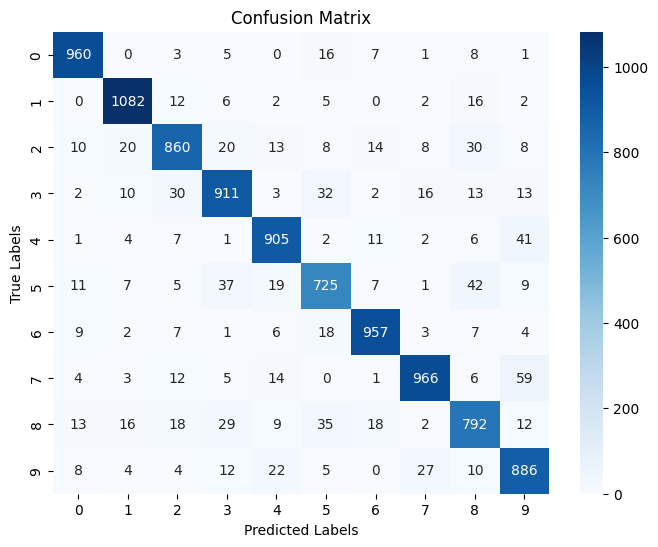

In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(cm, num_classes)

### HyperParameter Tuning

####Experiment Batch Size

In [ ]:
def experiment_batch_size(X_train, y_train, X_validation, y_validation, input_dim, num_classes, batch_sizes, weight_initialization='normal', learning_rate=5e-4, l2_reg_coefficient=1e-4, epochs=100):
    all_epoch_accuracies = []

    for batch_size in batch_sizes:
        print(f"\nExperimenting with Batch Size: {batch_size}")
        _, epoch_accuracies = train_logistic_regression(X_train, y_train, X_validation, y_validation, input_dim, num_classes, weight_initialization, learning_rate, batch_size, l2_reg_coefficient, epochs)
        all_epoch_accuracies.append((batch_size, epoch_accuracies))

    return all_epoch_accuracies

In [ ]:
def plot_batch_size_experiment(all_epoch_accuracies):
    # Plot the results with legends
    plt.figure(figsize=(8, 6))
    for i, (batch_size, epoch_accuracies) in enumerate(all_epoch_accuracies):
        plt.plot(epoch_accuracies[:, 0], epoch_accuracies[:, 1], label=f'Batch Size {batch_size}', marker='o')

    plt.title("Effect of Batch Size on Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [ ]:
# Experiment with Batch Size
batch_sizes_to_try = [1, 64, 50000]
all_epoch_accuracies_batch_size = experiment_batch_size(X_train, y_train, X_validation, y_validation, input_dim, num_classes, batch_sizes_to_try)


Experimenting with Batch Size: 1
Validation Accuracy: 64.60%
Epoch 1/100, Loss: 9.77851521674781, Validation Accuracy: 64.60%
Validation Accuracy: 74.33%
Epoch 2/100, Loss: 0.3764785024632257, Validation Accuracy: 74.33%
Validation Accuracy: 77.76%
Epoch 3/100, Loss: 0.3720860609841187, Validation Accuracy: 77.76%
Validation Accuracy: 79.82%
Epoch 4/100, Loss: 0.36812971923141063, Validation Accuracy: 79.82%
Validation Accuracy: 81.40%
Epoch 5/100, Loss: 4.5976363530736695, Validation Accuracy: 81.40%
Validation Accuracy: 82.44%
Epoch 6/100, Loss: 0.364149373698156, Validation Accuracy: 82.44%
Validation Accuracy: 83.27%
Epoch 7/100, Loss: 0.35988347219463745, Validation Accuracy: 83.27%
Validation Accuracy: 83.85%
Epoch 8/100, Loss: 0.36492702814985617, Validation Accuracy: 83.85%
Validation Accuracy: 84.55%
Epoch 9/100, Loss: 0.35188184339502804, Validation Accuracy: 84.55%
Validation Accuracy: 84.99%
Epoch 10/100, Loss: 0.3491244423188498, Validation Accuracy: 84.99%
Validation Acc

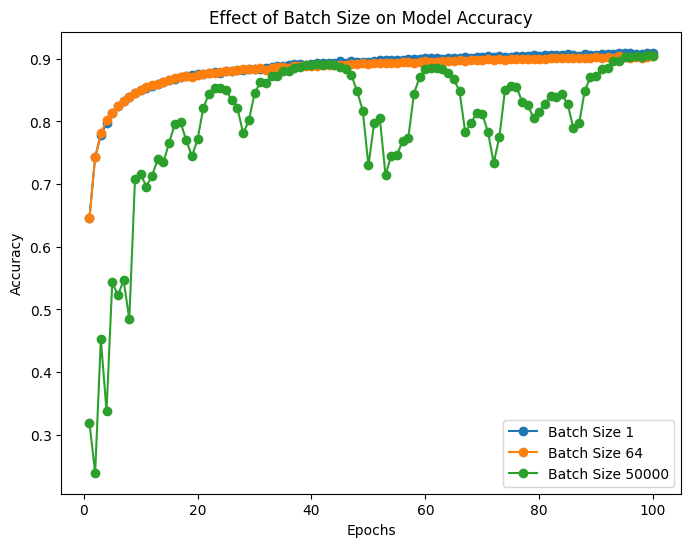

In [ ]:
#plot the results
plot_batch_size_experiment(all_epoch_accuracies_batch_size)

#### Experiment Weight initializer

In [ ]:
def experiment_weight_initializer(X_train, y_train,  X_validation, y_validation, input_dim, num_classes, initializers, batch_size = 200, learning_rate=5e-4, l2_reg_coefficient=1e-4, epochs=100):
    all_epoch_accuracies = []
    for initializer in initializers:
        print(f"\nExperimenting with initializer: {initializer}")
        _, epoch_accuracies = train_logistic_regression(X_train, y_train,  X_validation, y_validation, input_dim, num_classes, initializer, learning_rate, batch_size, l2_reg_coefficient, epochs)
        all_epoch_accuracies.append((initializer, epoch_accuracies))

    return all_epoch_accuracies

In [ ]:
def plot_weight_initializer_experiment(all_epoch_accuracies):
    # Plot the results with legends
    plt.figure(figsize=(8, 6))
    for i, (initializer, epoch_accuracies) in enumerate(all_epoch_accuracies):
        plt.plot(epoch_accuracies[:, 0], epoch_accuracies[:, 1], label=f'Initializer: {initializer}', marker='o')

    plt.title("Effect of Weight Initilizers on Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [ ]:
# Experiment with Weight Initializers
initializers = ['zero', 'uniform', 'normal']
all_epoch_accuracies_weight_initializer = experiment_weight_initializer(X_train, y_train, X_validation, y_validation, input_dim, num_classes, initializers)


Experimenting with initializer: zero
Validation Accuracy: 88.42%
Epoch 1/100, Loss: 0.3922792390268489, Validation Accuracy: 88.42%
Validation Accuracy: 89.52%
Epoch 2/100, Loss: 0.5499408694088758, Validation Accuracy: 89.52%
Validation Accuracy: 90.11%
Epoch 3/100, Loss: 0.41857385649514667, Validation Accuracy: 90.11%
Validation Accuracy: 90.45%
Epoch 4/100, Loss: 0.3070387174874023, Validation Accuracy: 90.45%
Validation Accuracy: 90.67%
Epoch 5/100, Loss: 0.36197471373688095, Validation Accuracy: 90.67%
Validation Accuracy: 90.93%
Epoch 6/100, Loss: 0.3253142451038255, Validation Accuracy: 90.93%
Validation Accuracy: 91.05%
Epoch 7/100, Loss: 0.30627829477951335, Validation Accuracy: 91.05%
Validation Accuracy: 91.27%
Epoch 8/100, Loss: 0.3953231323179177, Validation Accuracy: 91.27%
Validation Accuracy: 91.30%
Epoch 9/100, Loss: 0.34363859611430625, Validation Accuracy: 91.30%
Validation Accuracy: 91.36%
Epoch 10/100, Loss: 0.22732449199048882, Validation Accuracy: 91.36%
Valida

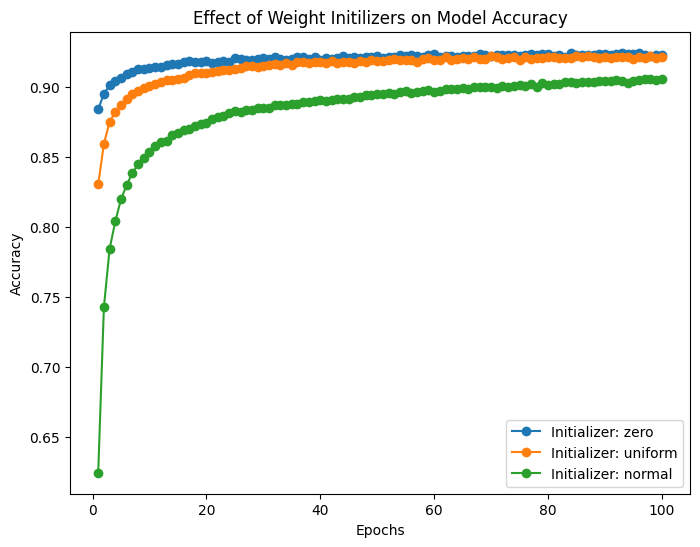

In [ ]:
#plot the results
plot_weight_initializer_experiment(all_epoch_accuracies_weight_initializer)

#### Experiment Learning Rate

In [ ]:
# Function to experiment with learning rates
def experiment_learning_rate(X_train, y_train,  X_validation, y_validation, input_dim, num_classes, learning_rates, weight_initialization ='normal', batch_size=200, l2_reg_coefficient=1e-4, epochs=100):
    all_epoch_accuracies = []
    for learning_rate in learning_rates:
        print(f"\nExperimenting with Learning Rate: {learning_rate}")
        _, epoch_accuracies = train_logistic_regression(X_train, y_train, X_validation, y_validation, input_dim, num_classes, weight_initialization, learning_rate, batch_size, l2_reg_coefficient, epochs)
        all_epoch_accuracies.append((learning_rate, epoch_accuracies))

    return all_epoch_accuracies

In [ ]:
def plot_learning_rate_experiment(all_epoch_accuracies):
    # Plot the results with legends
    plt.figure(figsize=(8, 6))
    for i, (learning_rate, epoch_accuracies) in enumerate(all_epoch_accuracies):
        plt.plot(epoch_accuracies[:, 0], epoch_accuracies[:, 1], label=f'Learning_rate: {learning_rate}', marker='o')

    plt.title("Effect of Learning Rates on Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [ ]:
# Experiment with Learning Rates
learning_rates = [1e-1, 1e-3, 1e-4, 1e-5]
all_epoch_accuracies_learning_rate = experiment_learning_rate(X_train, y_train,  X_validation, y_validation, input_dim, num_classes, learning_rates)


Experimenting with Learning Rate: 0.1
Validation Accuracy: 89.03%
Epoch 1/100, Loss: 3.810431850154, Validation Accuracy: 89.03%
Validation Accuracy: 89.55%
Epoch 2/100, Loss: 3.2823316506863995, Validation Accuracy: 89.55%
Validation Accuracy: 89.17%
Epoch 3/100, Loss: 3.911491904154533, Validation Accuracy: 89.17%
Validation Accuracy: 87.73%
Epoch 4/100, Loss: 3.7106945697554092, Validation Accuracy: 87.73%
Validation Accuracy: 71.86%
Epoch 5/100, Loss: 9.388162317270572, Validation Accuracy: 71.86%
Validation Accuracy: 90.29%
Epoch 6/100, Loss: 4.425966281441974, Validation Accuracy: 90.29%
Validation Accuracy: 86.73%
Epoch 7/100, Loss: 5.0033619911706, Validation Accuracy: 86.73%
Validation Accuracy: 89.19%
Epoch 8/100, Loss: 4.863442884276404, Validation Accuracy: 89.19%
Validation Accuracy: 90.41%
Epoch 9/100, Loss: 3.6880426263319386, Validation Accuracy: 90.41%
Validation Accuracy: 89.18%
Epoch 10/100, Loss: 5.28668865469867, Validation Accuracy: 89.18%
Validation Accuracy: 90

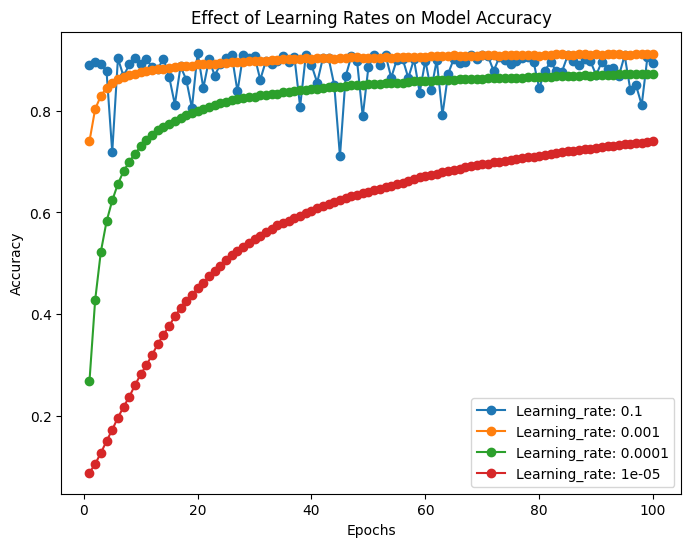

In [ ]:
# Plot the results
plot_learning_rate_experiment(all_epoch_accuracies_learning_rate)

#### Experiment with Regularization Coefficient

In [ ]:
# Function to experiment with regularization coefficients
def experiment_regularization_coefficient(X_train, y_train, X_validation, y_validation, input_dim, num_classes, reg_coefficients, weight_initialization ='normal', learning_rate=5e-4, batch_size=200, epochs=100):
    all_epoch_accuracies = []

    for reg_coefficient in reg_coefficients:
        print(f"\nExperimenting with Regularization Coefficient: {reg_coefficient}")
        _, epoch_accuracies = train_logistic_regression(X_train, y_train,  X_validation, y_validation, input_dim, num_classes, weight_initialization, learning_rate, batch_size, reg_coefficient, epochs)
        all_epoch_accuracies.append((reg_coefficient, epoch_accuracies))

    return all_epoch_accuracies

In [ ]:
def plot_regularization_coefficient_experiment(all_epoch_accuracies):
    # Plot the results with legends
    plt.figure(figsize=(8, 6))
    for i, (reg_coefficient, epoch_accuracies) in enumerate(all_epoch_accuracies):
        plt.plot(epoch_accuracies[:, 0], epoch_accuracies[:, 1], label=f'reg_coefficient: {reg_coefficient}', marker='o')

    plt.title("Effect of Regularization Coefficents on Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [ ]:
# Experiment with Regularization Coefficients
reg_coefficients = [1e-2, 1e-4, 1e-9]
all_epoch_accuracies_reg_coefficients = experiment_regularization_coefficient(X_train, y_train, X_validation, y_validation, input_dim, num_classes, reg_coefficients)


Experimenting with Regularization Coefficient: 0.01
Validation Accuracy: 64.87%
Epoch 1/100, Loss: 40.441546852294, Validation Accuracy: 64.87%
Validation Accuracy: 73.97%
Epoch 2/100, Loss: 39.76051009845968, Validation Accuracy: 73.97%
Validation Accuracy: 78.06%
Epoch 3/100, Loss: 38.88518689890309, Validation Accuracy: 78.06%
Validation Accuracy: 80.62%
Epoch 4/100, Loss: 38.363603657187255, Validation Accuracy: 80.62%
Validation Accuracy: 81.87%
Epoch 5/100, Loss: 38.26962964869764, Validation Accuracy: 81.87%
Validation Accuracy: 83.22%
Epoch 6/100, Loss: 37.9560391910577, Validation Accuracy: 83.22%
Validation Accuracy: 83.98%
Epoch 7/100, Loss: 37.477695104596165, Validation Accuracy: 83.98%
Validation Accuracy: 84.55%
Epoch 8/100, Loss: 37.268831227236134, Validation Accuracy: 84.55%
Validation Accuracy: 85.12%
Epoch 9/100, Loss: 36.952170691463486, Validation Accuracy: 85.12%
Validation Accuracy: 85.46%
Epoch 10/100, Loss: 36.703834492190225, Validation Accuracy: 85.46%
Vali

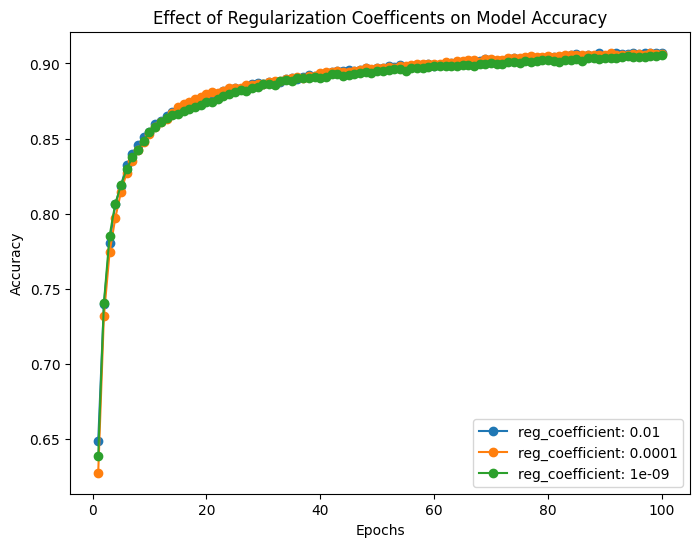

In [ ]:
#Plot the results
plot_regularization_coefficient_experiment(all_epoch_accuracies_reg_coefficients)

### Train The Best Model

In [27]:
# Hyperparameters
num_classes = 10
input_dim = X_train.shape[1]
learning_rate = 1e-3
batch_size = 64
initializer = 'zero'
l2_reg_coefficient = 1e-2
epochs = 100

#Merge train and validation set
X_train_final = np.concatenate((X_validation, X_train), axis=0)
y_train_final = np.concatenate((y_validation, y_train), axis=0)

# Train The Best Model #Validation accuracy is biased in this model since we train our model also with validation set
# but we will test it for the test set later
trained_weights, default_epoch_accuracy = train_logistic_regression(X_train_final, y_train_final, X_validation, y_validation, input_dim, num_classes, initializer, learning_rate, batch_size, l2_reg_coefficient, epochs)

Validation Accuracy: 89.83%
Epoch 1/100, Loss: 0.5203466233825761, Validation Accuracy: 89.83%
Validation Accuracy: 90.87%
Epoch 2/100, Loss: 0.6392437095658694, Validation Accuracy: 90.87%
Validation Accuracy: 91.46%
Epoch 3/100, Loss: 0.6576483626796037, Validation Accuracy: 91.46%
Validation Accuracy: 91.66%
Epoch 4/100, Loss: 0.7480793713989249, Validation Accuracy: 91.66%
Validation Accuracy: 91.82%
Epoch 5/100, Loss: 0.5239193158643791, Validation Accuracy: 91.82%
Validation Accuracy: 91.84%
Epoch 6/100, Loss: 0.582487269233392, Validation Accuracy: 91.84%
Validation Accuracy: 92.12%
Epoch 7/100, Loss: 0.8128066325410626, Validation Accuracy: 92.12%
Validation Accuracy: 92.18%
Epoch 8/100, Loss: 0.8133204880656971, Validation Accuracy: 92.18%
Validation Accuracy: 92.35%
Epoch 9/100, Loss: 0.8624670034188913, Validation Accuracy: 92.35%
Validation Accuracy: 92.41%
Epoch 10/100, Loss: 0.8585343361281783, Validation Accuracy: 92.41%
Validation Accuracy: 92.64%
Epoch 11/100, Loss: 0.

In [28]:
# Evaluate Model On The Test Set
cm = evaluate_model(X_test, y_test, trained_weights)[1]

Validation Accuracy: 92.50%


In [29]:
trained_weights.shape

(784, 10)

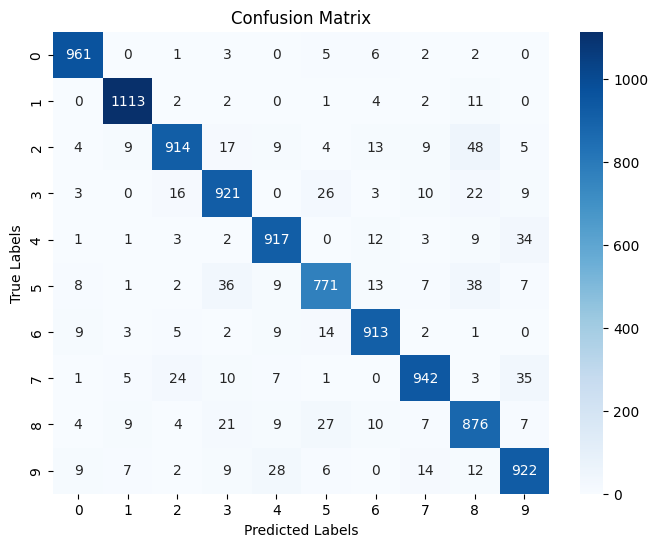

In [30]:
# Plot Confusion Matrix
plot_confusion_matrix(cm, num_classes)

### Visualize Weight Vectors

In [ ]:
def visualize_weight_as_image(weight, columns, cmap=plt.cm.gray):
    weight = weight.T

    for vector in weight:
      # Reshape the weight vector into a square matrix (assuming it's a flattened image)
      side_length = int(np.sqrt(len(vector)))
      weight_matrix = vector.reshape((side_length, side_length))

      # Display the image using Matplotlib
      plt.matshow(weight_matrix, cmap=cmap, vmin=0.5 * vector.min(), vmax=0.5 * vector.max())

    plt.show()

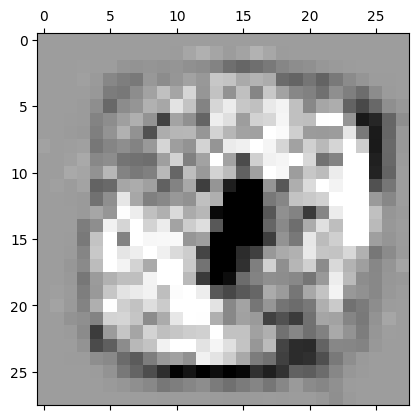

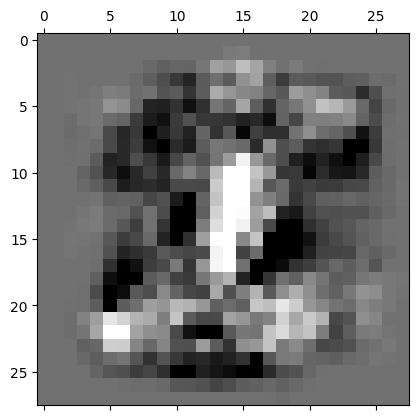

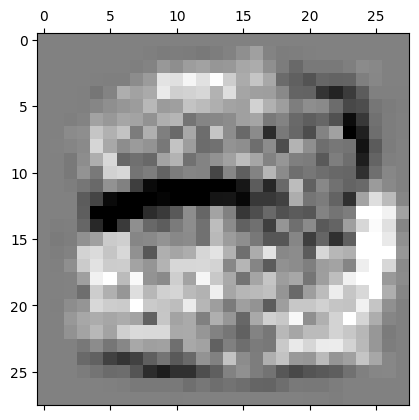

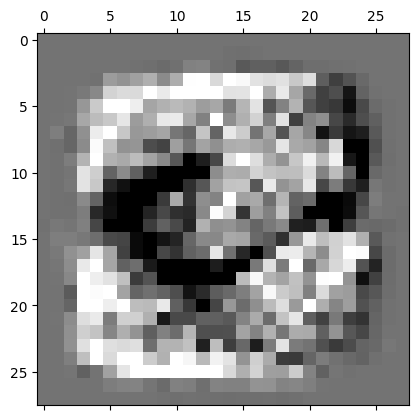

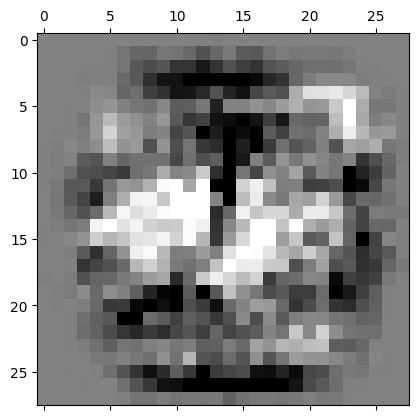

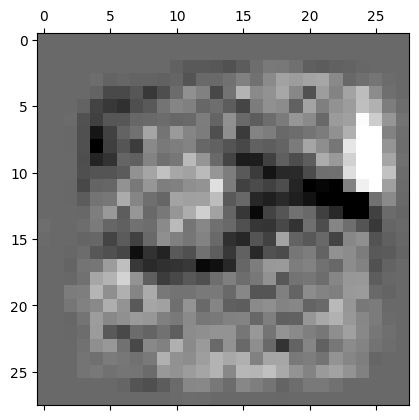

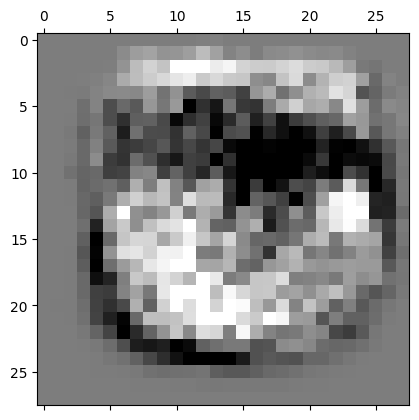

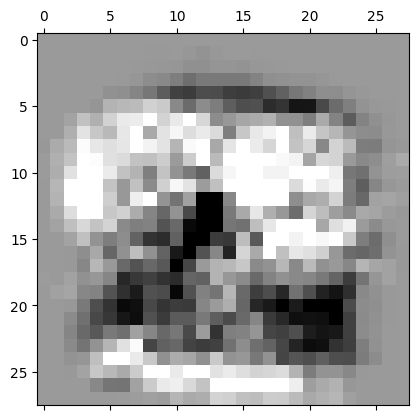

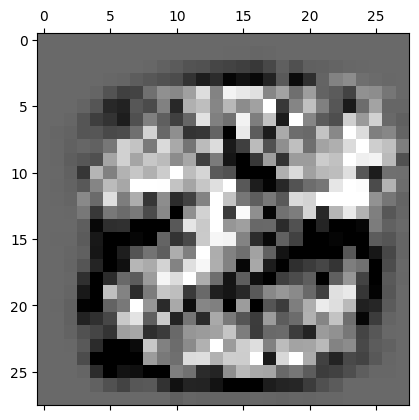

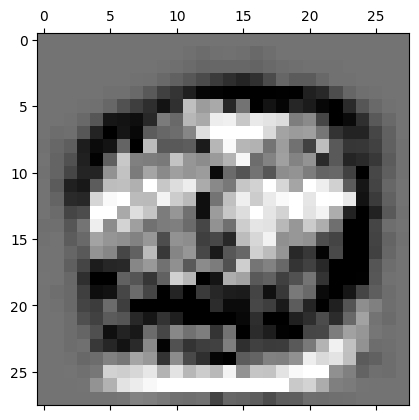

In [ ]:
visualize_weight_as_image(trained_weights, input_dim)

### Calculate Precision, Recall, F1 Score and F2 Score for each class

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score

def print_class_metrics(y_true, X_test, weights, beta=2):
    softmax_probs_validation = logistic_regression(X_test, weights)
    y_pred = np.argmax(softmax_probs_validation, axis=1)
    y_pred = one_hot_encoding(y_pred)

    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    f2 = fbeta_score(y_true, y_pred, beta=beta, average=None)

    for i in range(len(precision)):
        print(f"Class {i}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, F1 Score = {f1[i]:.4f}, F{beta} Score = {f2[i]:.4f}")

In [38]:
print_class_metrics(y_test, X_test, trained_weights)

Class 0: Precision = 0.9610, Recall = 0.9806, F1 Score = 0.9707, F2 Score = 0.9766
Class 1: Precision = 0.9695, Recall = 0.9806, F1 Score = 0.9750, F2 Score = 0.9784
Class 2: Precision = 0.9394, Recall = 0.8857, F1 Score = 0.9117, F2 Score = 0.8959
Class 3: Precision = 0.9003, Recall = 0.9119, F1 Score = 0.9061, F2 Score = 0.9095
Class 4: Precision = 0.9281, Recall = 0.9338, F1 Score = 0.9310, F2 Score = 0.9327
Class 5: Precision = 0.9018, Recall = 0.8643, F1 Score = 0.8827, F2 Score = 0.8716
Class 6: Precision = 0.9374, Recall = 0.9530, F1 Score = 0.9451, F2 Score = 0.9499
Class 7: Precision = 0.9439, Recall = 0.9163, F1 Score = 0.9299, F2 Score = 0.9217
Class 8: Precision = 0.8571, Recall = 0.8994, F1 Score = 0.8778, F2 Score = 0.8906
Class 9: Precision = 0.9048, Recall = 0.9138, F1 Score = 0.9093, F2 Score = 0.9120
